## DoubleDQN with Prioritized Replay (PER) and Dueling Network Architecture

Pytorch Learning rate is also Annealed throughout beginning of learning to enable larger updates at first.

### Import Required Libraries

In [1]:
import math, random, time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

from common.replay_buffer import PrioritizedReplayBuffer

device = "cuda" if torch.cuda.is_available() else "cpu"

### Build Prioritized Memory Replay Buffer

In [2]:
class NaivePrioritizedBuffer(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity   = capacity
        self.buffer     = []
        self.pos        = 0
        self.priorities = np.zeros((capacity,), dtype=np.float32)
    
    def add(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        max_prio = self.priorities.max() if self.buffer else 1.0
        
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)
        
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity
    
    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]
        
        probs  = prios ** self.prob_alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]
        
        total    = len(self.buffer)
        weights  = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights  = np.array(weights, dtype=np.float32)
        
        batch       = list(zip(*samples))
        states      = np.concatenate(batch[0])
        actions     = batch[1]
        rewards     = batch[2]
        next_states = np.concatenate(batch[3])
        dones       = batch[4]
        
        return [torch.FloatTensor(states), torch.LongTensor(actions),
                torch.FloatTensor(rewards), torch.FloatTensor(next_states),
                torch.FloatTensor(dones), indices, torch.FloatTensor(weights)]
    
    def update_priorities(self, batch_indices, batch_priorities):
        for batch_index, priority in zip(batch_indices, batch_priorities):
            self.priorities[batch_index] = priority

    def __len__(self):
        return len(self.buffer)


### Build Lambda Functions for Epsilon Greedy Strategy and Annealing of PER's beta parameter 

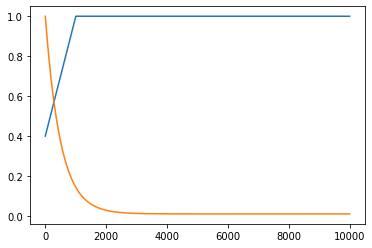

In [3]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

plt.plot([beta_by_frame(i) for i in range(10000)])

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

plt.plot([epsilon_by_frame(i) for i in range(10000)])

### Build Classes for DQN and Dueling DQN (Linear)

In [4]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def choose_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = torch.from_numpy(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

class DuelingDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DuelingDQN, self).__init__()
        
        
        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )
        
        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )
        
        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        x = self.feature(x)
        advantage = self.advantage(x)
        value     = self.value(x)
        return value + advantage  - advantage.mean()
    
    def choose_action(self, state, epsilon):
        if random.random() > epsilon:
            with torch.no_grad():
                state   = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

### Build Functions for computing the temporal difference loss.

In [5]:
def compute_td_loss_double_huber(batch_size, beta):
    """
    For double DQN we use the policy network for estimating the  current and next q values
    whilst using the target network also to estimate the next q values.
    The estimates for the next q values from the policy network are then used to pick the next action whilst the
    estimate from the policy nextwork is then used to rate how good that action was.
    """
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    state      = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action     = torch.LongTensor(action)
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(done)
    weights    = torch.FloatTensor(weights)
    
    q_values      = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state) 

    q_value       = q_values.gather(1, action.unsqueeze(1)).squeeze(1) 
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss  = F.smooth_l1_loss(q_value, expected_q_value.detach(), reduction='none') * weights
    priorities = loss + 1e-5
    loss = loss.mean()

    indices = [int(i) for i in indices]
    
    replay_buffer.update_priorities(indices, priorities.data.cpu().numpy())

    return loss


### Helper Functions for plotting and model updates

In [6]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    ax1 = plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    ax2 = plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

### Train DQN and save model after various training periods.

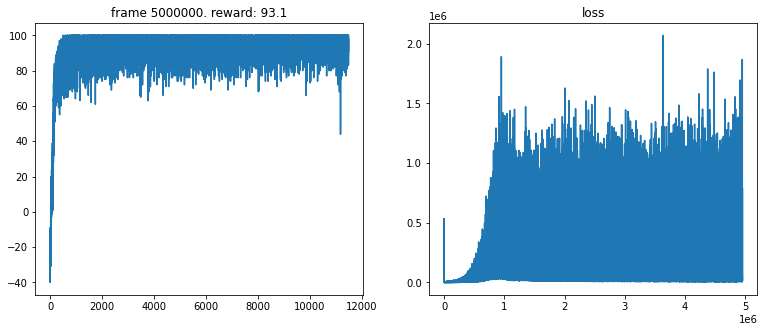

Learning Rate Set to: 4.71e-05
Percentage of Frames Complete: 100.00


In [9]:
#Hyperparameters
num_frames             = 5e6
model_save_frames      = [1e4, 1e5, 2.5e5, 5e5, 1e6, 2e6, 3e6, 4e6, 5e6]
batch_size             = 64
pre_warm_memory_size   = 5e4
gamma                  = 0.99
target_network_refresh = 100
buffer_size            = int(1e6)
learning_rate          = 1e-3
decay_rate             = 0.9
min_learning_rate      = 5e-5
alpha                  = 0.6

#Toggles
dueling_dqn            = True
render                 = False
decay_learning_rate    = True

#Initialize Counters/Variables
losses                 = []
all_rewards            = []
episode_reward         = 0
buffer_warmed          = False
env_id                 = "Boxing-ram-v0"
env = gym.make(env_id)
state = env.reset()
assert pre_warm_memory_size >= batch_size 

##########################################################
##########################################################

if dueling_dqn:
    current_model = DuelingDQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_model  = DuelingDQN(env.observation_space.shape[0], env.action_space.n).to(device)
else:
    current_model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    target_model  = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
target_model.eval()

update_target(current_model, target_model)

optimizer = optim.Adam(current_model.parameters(), lr=learning_rate)
my_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

replay_buffer = PrioritizedReplayBuffer(buffer_size, alpha)

##########################################################
##########################################################

for frame_idx in range(1, int(num_frames) + 1):
    if render:
        env.render()
    epsilon = epsilon_by_frame(frame_idx)
    action = current_model.choose_action(state, epsilon)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > pre_warm_memory_size:
        beta = beta_by_frame(frame_idx)
        loss = compute_td_loss_double_huber(batch_size, beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        buffer_warmed = True
        
    if frame_idx % 2000 == 0:
        plot(frame_idx, all_rewards, losses)
        print("Learning Rate Set to: {:.2e}".format(scheduler_learning_rate))
        print("Percentage of Frames Complete: {:.2f}".format(100 * frame_idx / num_frames))
        
    if frame_idx % target_network_refresh == 0:
        update_target(current_model, target_model)
    
    if frame_idx in model_save_frames:
        torch.save(current_model, "./models/openai_%s_%s.model" % (env_id, frame_idx))
        
    if decay_learning_rate and frame_idx % target_network_refresh == 0:
        scheduler_learning_rate = my_lr_scheduler.get_lr()[0]
        if scheduler_learning_rate > min_learning_rate and buffer_warmed:
            my_lr_scheduler.step()
            